In [1]:
# !pip install torch torchvision --quiet   # (uncomment on Colab)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time, copy, os

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch version: 2.5.1
Device: cuda


## 1️⃣ Load the FashionMNIST dataset

In [ ]:
# PyTorch scaled 0-255 → 0-1 using transforms.ToTensor().

fashion_mnist_mean = (0.2859,)  # Approximate mean for FashionMNIST
fashion_mnist_std = (0.3530,)   # Approximate std for FashionMNIST

train_tfms = transforms.Compose([
    transforms.RandomCrop(28, padding=4),  # FashionMNIST is 28x28
    transforms.ToTensor(),
    transforms.Normalize(fashion_mnist_mean, fashion_mnist_std),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(fashion_mnist_mean, fashion_mnist_std)
])

data_path='./data'

train_set = datasets.FashionMNIST(root=data_path, train=True ,
                             download=True , transform=train_tfms)
test_set  = datasets.FashionMNIST(root=data_path, train=False,
                             download=True , transform=test_tfms)

class_names = train_set.classes   # identical to your list
print("Training data:", len(train_set))
print("Testing  data:", len(test_set))

BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set , batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

Training data: 60000
Testing  data: 10000


## 2️⃣ Visualize raw images 

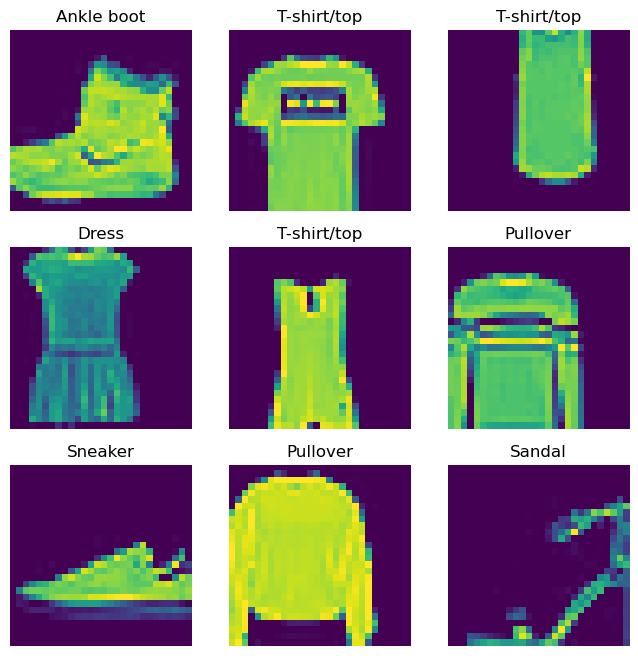

In [3]:
def imshow(inp, title=None):
    # inp: (C,H,W) tensor in [0,1]
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title: plt.title(title)
    plt.axis("off")

plt.figure(figsize=(8,8))
for i,(img,lbl) in enumerate(train_set):
    if i==9: break
    plt.subplot(3,3,i+1)
    imshow(img, class_names[lbl])
plt.show()

## 3️⃣ Data augmentation + normalization

In [4]:
# We rebuild a new dataset with augmentation only for training.
aug_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),                       # ~0.1 rad
    transforms.RandomResizedCrop(28, scale=(0.9,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(fashion_mnist_mean, fashion_mnist_std),
])


train_set_aug = datasets.FashionMNIST(root=data_path, train=True,
                                 download=False, transform=aug_tfms)
train_loader_aug = DataLoader(train_set_aug, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2, pin_memory=True)

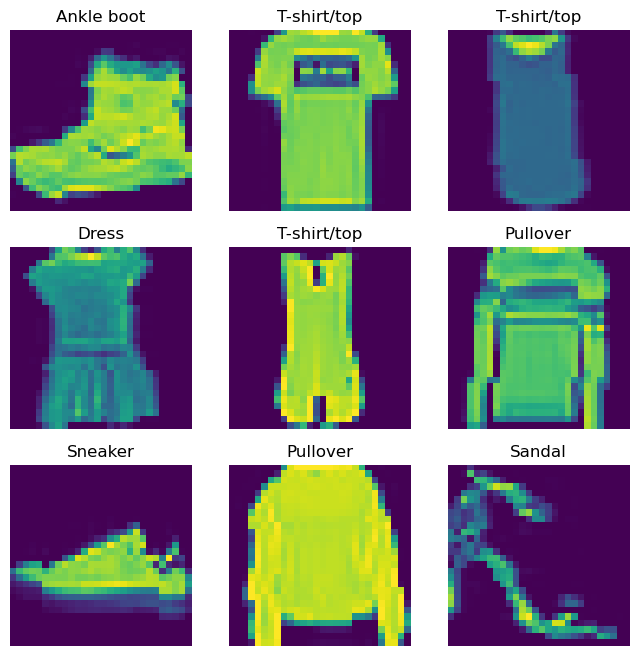

In [5]:
plt.figure(figsize=(8,8))
for i,(img,lbl) in enumerate(train_set_aug):
    if i==9: break
    plt.subplot(3,3,i+1)
    imshow(img, class_names[lbl])
plt.show()

## 4️⃣ Define training function

In [6]:
def train_model(model, dataloaders, criterion, optimizer, epochs=15):
    history = {"train_acc":[], "val_acc":[]}
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total = 0

            loader = dataloaders[phase]
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase=="train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)

            epoch_acc = running_corrects.double() / total
            if phase=="train":
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_acc"].append(epoch_acc.item())

            print(f"  {phase:5s} | loss {running_loss/total:.4f} | acc {epoch_acc:.4f}")

            if phase=="val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())

    print(f"Best val acc: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, history

## 5️⃣.1 Define the ANN model

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten N,C,H,W ➜ N,784
        return self.net(x)

ann_model = ANN().to(device)

print(ann_model)


ANN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 5️⃣.2 Define the CNN model

In [8]:

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (32,H,W)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # (32,H/2,W/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64,H/2,W/2)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # (64,H/4,W/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (64,H/4,W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # (64,H/8,W/8)
        )
        
        # Adaptive pooling to handle any input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Always output 4x4
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 64),  # Fixed size: 64*4*4 = 1024
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)  # Ensures consistent size
        x = self.classifier(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1)

In [9]:
print(f"ANN Parameters: {sum(p.numel() for p in ann_model.parameters()):,}")
print(f"CNN Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

ANN Parameters: 567,434
CNN Parameters: 224,906


## 6️⃣ Loss, Optimizer, Scheduler 

In [10]:
criterion = nn.CrossEntropyLoss()
ann_optimizer = optim.Adam(ann_model.parameters(), lr=1e-3)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

## 7️⃣.1 ANN Train & Validate loops 

In [11]:
dataloaders = {"train":train_loader_aug, "val":test_loader}
ann_model, ann_history = train_model(ann_model, dataloaders,
                             criterion, ann_optimizer, epochs=15)


Epoch 1/15
  train | loss 0.6017 | acc 0.7752
  val   | loss 0.4534 | acc 0.8327
Epoch 2/15
  train | loss 0.4799 | acc 0.8223
  val   | loss 0.4145 | acc 0.8488
Epoch 3/15
  train | loss 0.4404 | acc 0.8363
  val   | loss 0.4028 | acc 0.8502
Epoch 4/15
  train | loss 0.4156 | acc 0.8449
  val   | loss 0.3751 | acc 0.8602
Epoch 5/15
  train | loss 0.4053 | acc 0.8487
  val   | loss 0.3688 | acc 0.8601
Epoch 6/15
  train | loss 0.3877 | acc 0.8562
  val   | loss 0.3808 | acc 0.8597
Epoch 7/15
  train | loss 0.3778 | acc 0.8576
  val   | loss 0.3579 | acc 0.8657
Epoch 8/15
  train | loss 0.3723 | acc 0.8605
  val   | loss 0.3667 | acc 0.8640
Epoch 9/15
  train | loss 0.3610 | acc 0.8643
  val   | loss 0.3560 | acc 0.8647
Epoch 10/15
  train | loss 0.3545 | acc 0.8657
  val   | loss 0.3435 | acc 0.8718
Epoch 11/15
  train | loss 0.3484 | acc 0.8683
  val   | loss 0.3547 | acc 0.8674
Epoch 12/15
  train | loss 0.3479 | acc 0.8679
  val   | loss 0.3559 | acc 0.8670
Epoch 13/15
  train | los

## 7️⃣.2 CNN Train & Validate loops 

In [12]:
cnn_model, cnn_history = train_model(cnn_model, dataloaders,
                             criterion, cnn_optimizer, epochs=15)

Epoch 1/15
  train | loss 0.5182 | acc 0.8083
  val   | loss 0.4808 | acc 0.8243
Epoch 2/15
  train | loss 0.3639 | acc 0.8640
  val   | loss 0.3260 | acc 0.8830
Epoch 3/15
  train | loss 0.3260 | acc 0.8793
  val   | loss 0.2816 | acc 0.8968
Epoch 4/15
  train | loss 0.3042 | acc 0.8866
  val   | loss 0.2821 | acc 0.8987
Epoch 5/15
  train | loss 0.2852 | acc 0.8944
  val   | loss 0.2512 | acc 0.9090
Epoch 6/15
  train | loss 0.2761 | acc 0.8960
  val   | loss 0.2691 | acc 0.9003
Epoch 7/15
  train | loss 0.2656 | acc 0.9030
  val   | loss 0.2477 | acc 0.9108
Epoch 8/15
  train | loss 0.2569 | acc 0.9049
  val   | loss 0.2474 | acc 0.9122
Epoch 9/15
  train | loss 0.2487 | acc 0.9082
  val   | loss 0.2378 | acc 0.9115
Epoch 10/15
  train | loss 0.2432 | acc 0.9097
  val   | loss 0.2324 | acc 0.9175
Epoch 11/15
  train | loss 0.2373 | acc 0.9125
  val   | loss 0.2254 | acc 0.9171
Epoch 12/15
  train | loss 0.2308 | acc 0.9151
  val   | loss 0.2287 | acc 0.9168
Epoch 13/15
  train | los

8️⃣ Final evaluation (test set)

In [13]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total

ann_test_acc = evaluate(ann_model, test_loader)
print("Test accuracy ANN Model:", ann_test_acc)


cnn_test_acc = evaluate(cnn_model, test_loader)
print("Test accuracy CNN Model:", cnn_test_acc)

Test accuracy ANN Model: 0.8737
Test accuracy CNN Model: 0.9217


9️⃣ Plot training vs validation accuracy

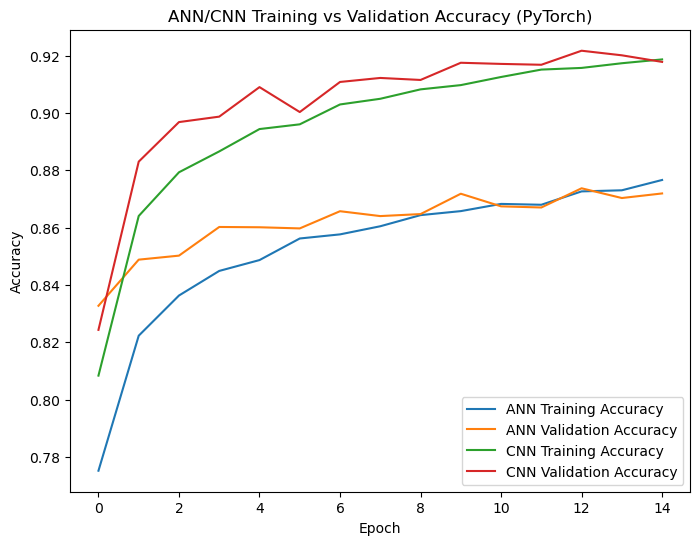

(<matplotlib.legend.Legend at 0x1c3945714e0>, None)

In [14]:
plt.figure(figsize=(8,6))
plt.plot(ann_history["train_acc"], label="ANN Training Accuracy")
plt.plot(ann_history["val_acc"  ], label="ANN Validation Accuracy")
plt.plot(cnn_history["train_acc"], label="CNN Training Accuracy")
plt.plot(cnn_history["val_acc"  ], label="CNN Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ANN/CNN Training vs Validation Accuracy (PyTorch)")
plt.legend(), plt.show()

## 🔟.1 ANN Predict and visualize results

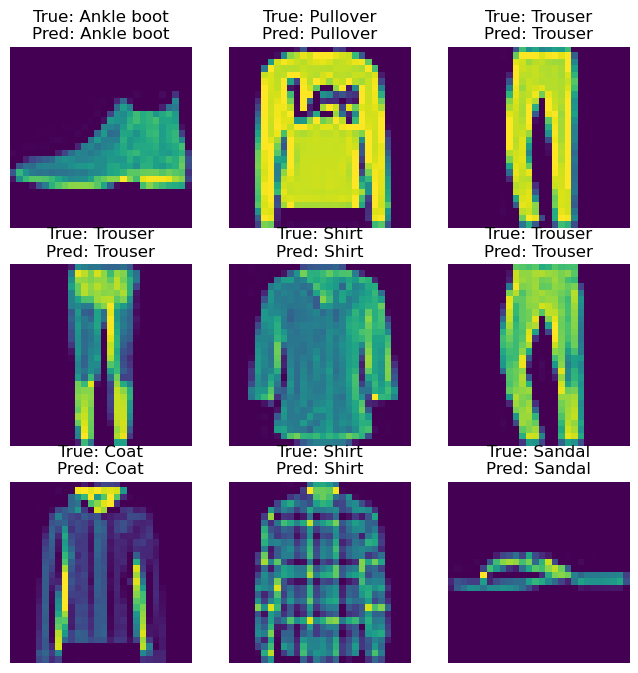

In [15]:
ann_model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    preds = ann_model(images).argmax(1)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(images[i].cpu(),
           f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
plt.show()

## 🔟.2 CNN Predict and visualize results

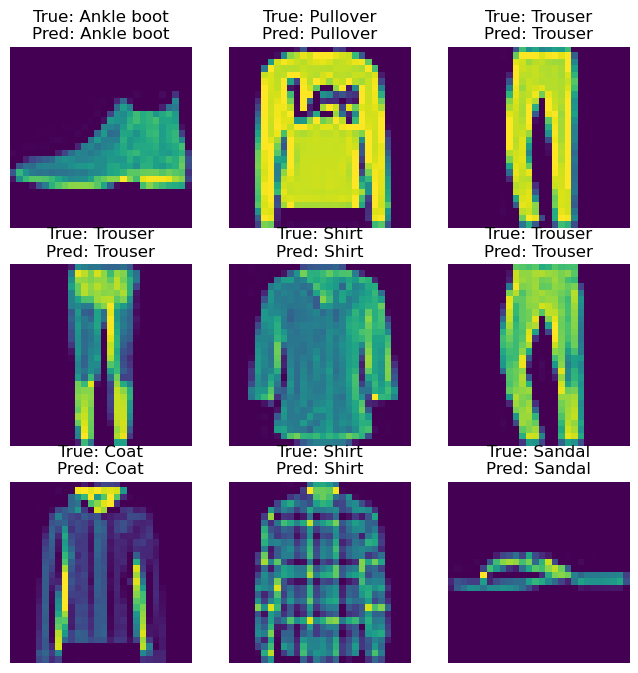

In [16]:
cnn_model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    preds = cnn_model(images).argmax(1)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(images[i].cpu(),
           f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
plt.show()

## 11. Plot Confusion Matrices

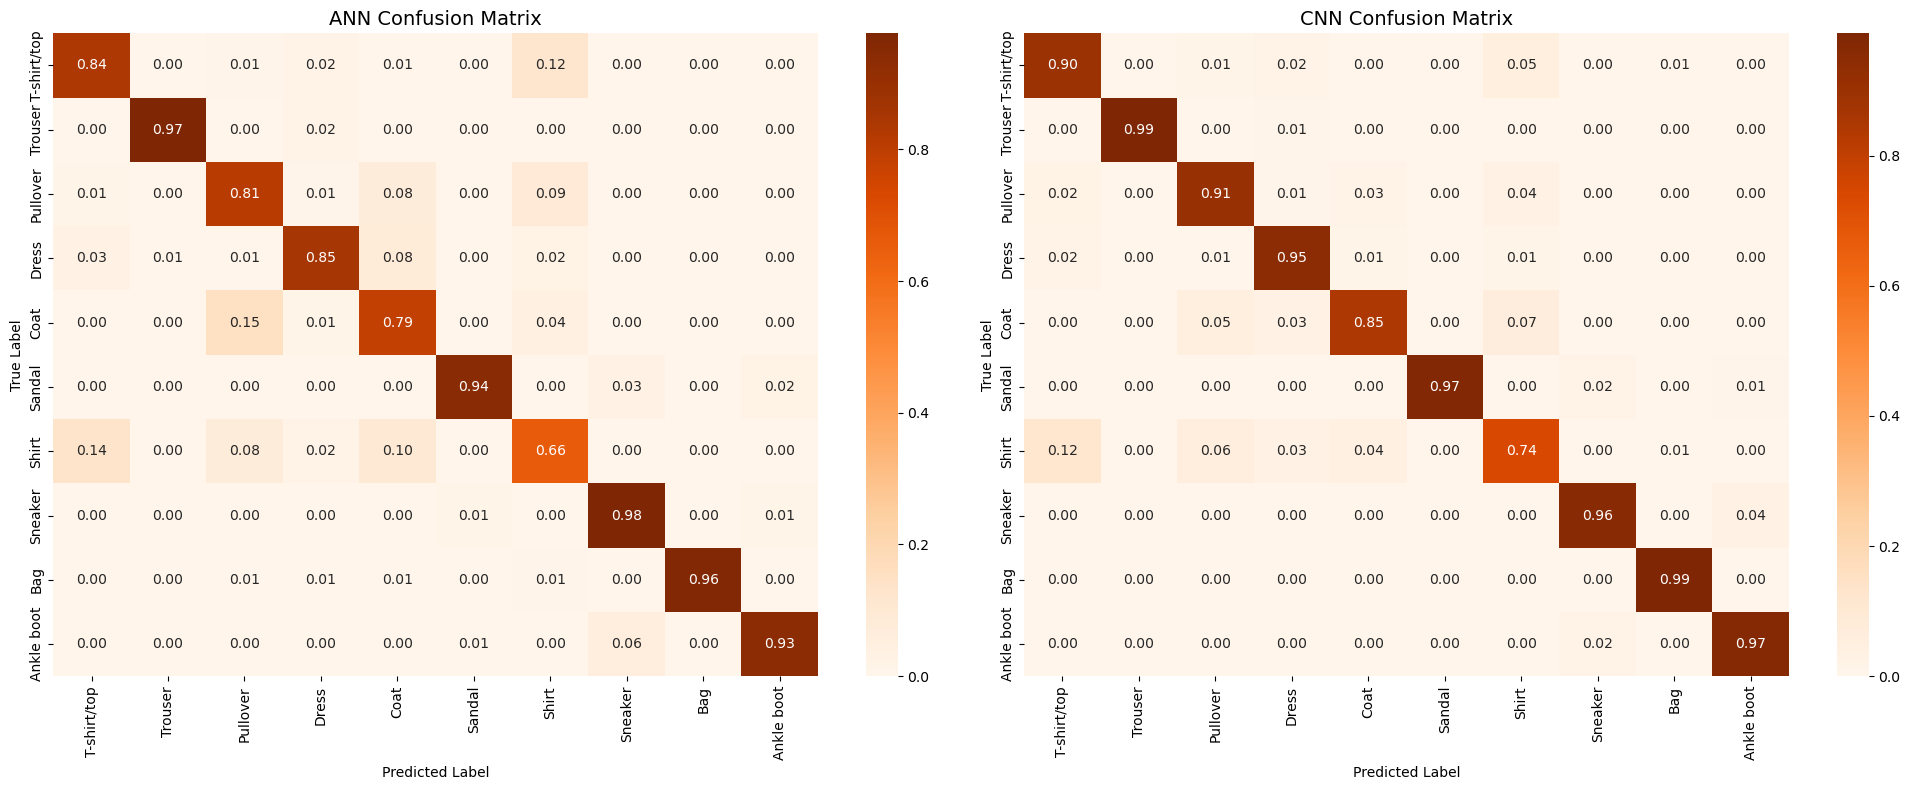

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

test_loader  = DataLoader(test_set , batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=0, pin_memory=True)

# Plot both models side by side
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Get predictions
ann_labels, ann_preds = get_predictions(ann_model, test_loader)
cnn_labels, cnn_preds = get_predictions(cnn_model, test_loader)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ANN confusion matrix
ann_cm = confusion_matrix(ann_labels, ann_preds, normalize='true')
sns.heatmap(ann_cm, annot=True, fmt='.2f', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title('ANN Confusion Matrix', fontsize=14)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# CNN confusion matrix  
cnn_cm = confusion_matrix(cnn_labels, cnn_preds, normalize='true')
sns.heatmap(cnn_cm, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title('CNN Confusion Matrix', fontsize=14)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

## 12. Save model to disk

In [19]:
torch.save(ann_model.state_dict(), "ann_fashion_mnist.pt")
torch.save(cnn_model.state_dict(), "cnn_fashion_mnist.pt")
# ann_model.load_state_dict(torch.load("ann_fashion_mnist.pt", weights_only=True))       # load
# cnn_model.load_state_dict(torch.load("cnn_fashion_mnist.pt", weights_only=True))       # load
# cnn_model.eval()
# cnn_model.eval()